<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Lab_2_(Intro_to_Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you do ANYTHING else in this notebook, you need to check Runtime -> Change Runtime Type and make sure it's a GUI because you need a GUI, and switching gives you a new kernel.

## Install and import relevant modules

In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import seaborn

In [0]:
assert torch.cuda.is_available() 

In [0]:
t = torch.tensor(np.arange(15).reshape(5,3).astype('float32'))
v = torch.tensor(np.array([1,2,0,2,0]).astype('float32'))
print(t)
print(v.size())
shifted = t - torch.max(t,dim=1)[0].unsqueeze(1)
#scores = torch.gather(shifted, 1, v.unsqueeze(1))
print(shifted)
#print(scores)
e = torch.exp(shifted)
print(torch.mean(torch.log(torch.sum(e,dim=1))))

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.]])
torch.Size([5])
tensor([[-2., -1.,  0.],
        [-2., -1.,  0.],
        [-2., -1.,  0.],
        [-2., -1.,  0.],
        [-2., -1.,  0.]])
tensor(0.4076)


## Follow along with video

In [0]:
class LinearNetwork(nn.Module):
  
  def __init__(self, dataset):
    """
    dataset
    
    x is a Torch tensor object, which has a size method (not attribute)
    out: output sizes
    
    Probably height, width for an image
    """
    
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    
    self.net = nn.Sequential(nn.Linear(c*h*w, out))
  
  def forward(self, x):
    """Forward computation graph."""
    
    n, c, h, w = x.size() 
    flattened = x.view(n, c*h*w)
    return self.net(flattened)
    
class FashionMNISTProcessedDataset(Dataset):
  
  def __init__(self, root, train=True):
    
    self.data = datasets.FashionMNIST(root, train=train, 
                                     transform=transforms.ToTensor(),
                                     download=True)
    
  def __getitem__(self, i):
    
    x, y = self.data[i]
    return x, y.unsqueeze(0).float()
  
  def __len__(self):
    # To do overfit and stuff, don't return the whole thing? Modify somehow?
    
    # Tell you how long the dataset is
    return len(self.data)

Load datasets?? Not sure where this is getting used anymore.

In [0]:
ds = datasets.FashionMNIST('/tmp/fashionmnist', train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

In [0]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
model = LinearNetwork(train_dataset)
model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)

num_epochs = 2
losses = []
for epoch in range(num_epochs):
  
  loop = tqdm(total=len(train_loader), position=0)
  
  for x, y_truth in train_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda()

    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update(1)
    loss.backward()
    optimizer.step()
    losses.append(loss)
  
  loop.close()

loss:2.6612: 100%|██████████| 1429/1429 [00:15<00:00, 89.88it/s]


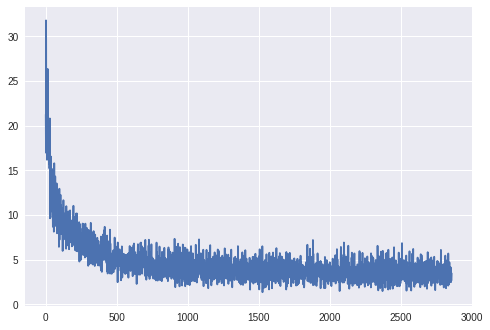

In [0]:
# plot this
loss_vals = [losses[i].item() for i in range(len(losses))]
plt.plot(loss_vals)
plt.show()

## My modified version

In [0]:
class LinearNetwork(nn.Module):
  
  def __init__(self, dataset):
    
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    
    self.net = nn.Sequential(nn.Linear(c*h*w, 1000), 
                             nn.Sigmoid(), 
                             nn.Linear(1000,out))
  
  def forward(self, x):
   
    n, c, h, w = x.size()
    flattened = x.view(n, c*h*w)
    return self.net(flattened)
    
class FashionMNISTProcessedDataset(Dataset):
  
  def __init__(self, root, train=True):
    
    self.data = datasets.FashionMNIST(root, train=train, 
                                     transform=transforms.ToTensor(),
                                     download=True)
    self.e = torch.eye(10)
    
  def __getitem__(self, i):
    
    x, y = self.data[i]
    return x, self.e[y].float()
  
  def __len__(self):
    
    # Do a really small batch so it overfits really bad
    return 42
    return len(self.data)

In [0]:

# For your own dataset, have to think about how to do test/train split
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
model = LinearNetwork(train_dataset)
model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)
val_batches = [(x, y_truth) for x, y_truth in val_loader]

losses = []
val_losses = []
num_epochs = 1000
loop = tqdm(total=len(train_loader)*1000, position=0)

for epoch in range(num_epochs):
  
    batch_index = 0
    for x, y_truth in train_loader:
        
        print(x.size(), y.size())
        assert 0==1


        x, y_truth = x.cuda(async=True), y_truth.cuda()
        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        losses.append(loss)

        vx, vy_truth = val_batches[batch_index]
        vx, vy_truth = vx.cuda(async=True), vy_truth.cuda()
        vhat = model(vx)
        vloss = objective(vhat, vy_truth)
        val_losses.append(vloss)
        batch_index += 1

        #loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)

        loss.backward()
        optimizer.step()

loop.close()

NameError: ignored

Green curve is the loss on the validation set, blue is the loss on the training set. Clear overfitting.

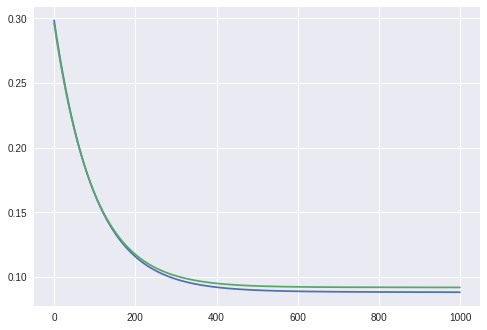

In [0]:
domain = range(len(losses))
loss_list = np.array([losses[i].item() for i in range(len(losses))])
val_loss_list = np.array([val_losses[i].item() for i in range(len(losses))])
plt.plot(domain, loss_list, domain, val_loss_list)
plt.show()

Especially as we increase the number of epochs.

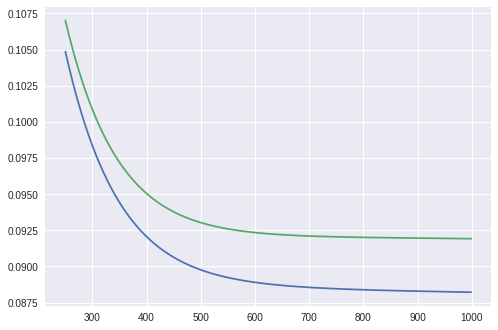

In [0]:
a = 250
b = 1000
plt.plot(domain[a:b], loss_list[a:b], domain[a:b], val_loss_list[a:b])
plt.show()

In [0]:
# Number of parameters
np.prod(np.array(list(model.parameters())[0].size()))

784000